In [17]:
import numpy as np
import h5py
import pandas as pd
from glob import glob
import os
import re
import seaborn as sns 
from glob import glob
import matplotlib.pyplot as plt 
from matplotlib import colors
import matplotlib.ticker as mticker
# settings
# color_pal = sns.color_palette()
from tqdm import tqdm

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
color_pal = sns.color_palette()

# Mute warnings
warnings.filterwarnings('ignore')

# Code imports
import PyBlastAfterglowMag as PBA
from paths import *
from settings import SIMULATIONS # list of the simulations
from paths import AFGRUNDIR

figs = os.getcwd() + "/figs_afg/"

# Collate data for a simulation

In [2]:
sim = SIMULATIONS["BHBLp_135_135_res150"]

lc_fname = "lc_kn.h5"
id_fname = "ejecta_id.h5"
lc_files = glob(AFGRUNDIR + sim["name"] + "/*/" + lc_fname)
id_files = glob(AFGRUNDIR + sim["name"] + "/*/" + id_fname)

workingdirs_lc = [lc_file.replace(lc_fname,"") for lc_file in lc_files]
workingdirs_id = [id_file.replace(id_fname,"") for id_file in id_files]

if len(workingdirs_lc) != len(workingdirs_id):
    missing = list(set(workingdirs_id)-set(workingdirs_lc))
    print(f"File number mismatch {len(lc_files)} - {len(id_files)}")
    print("Missing:")
    for f in missing:
        print(f"\t{f}")

workingdirs = workingdirs_lc
print(f"Number of working dirs: {len(workingdirs)}")

print(f"Files found: {len(lc_files)}")
print(f"Example: {lc_files[0]}")
file0 = h5py.File(lc_files[0],mode="r")
print(f"LC Keys: {file0.keys()}")
print(f"LC Attrs: {file0.attrs.keys()}")
file0.close()

file0 = h5py.File(id_files[0],mode="r")
print(f"ID Keys: {file0.keys()}")
print(f"ID Attrs: {file0.attrs.keys()}")
file0.close()

Number of working dirs: 6144
Files found: 6144
Example: /media/vsevolod/T7/work/prj_kn_afterglow/BHBLpTim326_135_135_45km_150mstg_B0_HLLC/kn_nism0001_thetaobs00_p22_epse0001_epsb0001_epst001_text30/lc_kn.h5
LC Keys: <KeysViewHDF5 ['freqs', 'times', 'total_fluxes']>
LC Attrs: <KeysViewHDF5 ['A0', 'Gamma_when_st_starts', 'a', 'd_l', 'eps_b', 'eps_e', 'eps_t', 'fraction_of_Gamma0_when_bm_for_bm', 'freq1', 'freq2', 'im_max_theta', 'iout', 'm_nlayers', 'mfac', 'n_ism', 'n_store_substeps', 'nfreq', 'nlayers', 'nmax', 'nshells', 'ntb', 'p', 'r_ej', 'r_ism', 'rtol', 'rtol_adapt', 's', 'save_dyn_every_it', 'steepnes_of_exp_decay', 'tb0', 'tb1', 'theta_obs', 'which_jet_layer_to_use', 'z']>
ID Keys: <KeysViewHDF5 ['ctheta', 'ek', 'entr', 'eps', 'mass', 'mom', 'press', 'r', 'rho', 'temp', 'theta', 'ye']>
ID Attrs: <KeysViewHDF5 ['text']>


In [4]:
# process working dirs -> Datagrame
prd = PBA.run_sets.CollateDataForRuns(workingdirs=workingdirs, key_to_key_map={
    "eps_e"     : "eps_e", 
    "eps_b"     : "eps_b", 
    "eps_t"     : "eps_t", 
    "p"         : "p", 
    "theta_obs" : "theta_obs", 
    "n_ism"     : "n_ism",
    "freq"      : "freq",
    "time"      : "time",
    "flux"      : "flux"
}, verbose = True)
fname = AFGRUNDIR + sim["name"] + '/' + "collated.csv"

### --- LUNCH ONLY ONCE ---
#prd.process(mode="KN", do_id=True, do_lc=True, do_skymap=False) # PROCESS ALL FILES
#prd.get_df().to_csv(AFGRUNDIR + sim["name"] + '/' + "collated.csv")

In [5]:
# Load dataframe
df = pd.read_csv(fname, index_col=0)
print(f"File saved: {fname} {print(df.info(memory_usage='deep'))}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5529600 entries, 0 to 5529599
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   eps_e      float64
 1   eps_b      float64
 2   eps_t      float64
 3   p          float64
 4   theta_obs  float64
 5   n_ism      float64
 6   freq       float64
 7   time       float64
 8   flux       float64
dtypes: float64(9)
memory usage: 421.9 MB
None
File saved: /media/vsevolod/T7/work/prj_kn_afterglow/BHBLpTim326_135_135_45km_150mstg_B0_HLLC/collated.csv None


# Analysis

In [7]:
from stat_analysis0 import DataSimulationRuns
    
#sim = SIMULATIONS["SFHo_q125_res150"]
dd = DataSimulationRuns(runs_dir = AFGRUNDIR+sim["name"]+"/")
# dd.process_runs(
#     frame = { "eps_e":[], "eps_b":[], "n_ism":[], 
#              "theta_obs":[], "freq":[], "time":[], "flux":[] },
#     outfname="collated.csv"
# )
# df = dd.load_processed_data(outfname="collated.csv")
# df.head()

In [8]:
eps_e = df["eps_e"].unique()
eps_t = df["eps_t"].unique()
eps_b = df["eps_b"].unique()
n_ism = df["n_ism"].unique()
theta_obs = df["theta_obs"].unique()
freq = df["freq"].unique()
print(f"eps_e = {len(eps_e)}, eps_b = {len(eps_b)}, eps_t = {len(eps_t)}, n_ism = {len(n_ism)}, \
        theta_obs = {len(theta_obs)}, freq = {len(freq)}")

eps_e = 4, eps_b = 4, eps_t = 4, n_ism = 4,         theta_obs = 6, freq = 6


In [9]:
# apply log to features
log_features = ["eps_e","eps_t","eps_b","n_ism","freq"]
df[log_features] = df[log_features].apply(np.log10)

In [10]:
# collect peak times and peak fluxes
idx = df.groupby(["eps_e","eps_t","eps_b","n_ism","theta_obs","freq"])["flux"].idxmax()
print(idx)

eps_e     eps_t  eps_b     n_ism  theta_obs  freq     
-3.00000  -2.0   -3.00000  -3.0   0.000000   9.380211         102
                                             9.903090         252
                                             10.204120        402
                                             10.431364        552
                                             10.612784        702
                                                           ...   
-0.30103   0.0   -0.30103   0.0   1.570796   9.903090     5528894
                                             10.204120    5529041
                                             10.431364    5529189
                                             10.612784    5529337
                                             10.968483    5356722
Name: flux, Length: 9216, dtype: int64


In [11]:
# locate maximum
max_fluxes = df.loc[idx]
print(max_fluxes.shape)
print(max_fluxes.head())

(9216, 9)
     eps_e  eps_b  eps_t    p  theta_obs  n_ism       freq          time  \
102   -3.0   -3.0   -2.0  2.2        0.0   -3.0   9.380211  5.248075e+07   
252   -3.0   -3.0   -2.0  2.2        0.0   -3.0   9.903090  5.248075e+07   
402   -3.0   -3.0   -2.0  2.2        0.0   -3.0  10.204120  5.248075e+07   
552   -3.0   -3.0   -2.0  2.2        0.0   -3.0  10.431364  5.248075e+07   
702   -3.0   -3.0   -2.0  2.2        0.0   -3.0  10.612784  5.248075e+07   

             flux  
102  1.077585e-07  
252  5.232684e-08  
402  3.452284e-08  
552  2.522088e-08  
702  1.962945e-08  


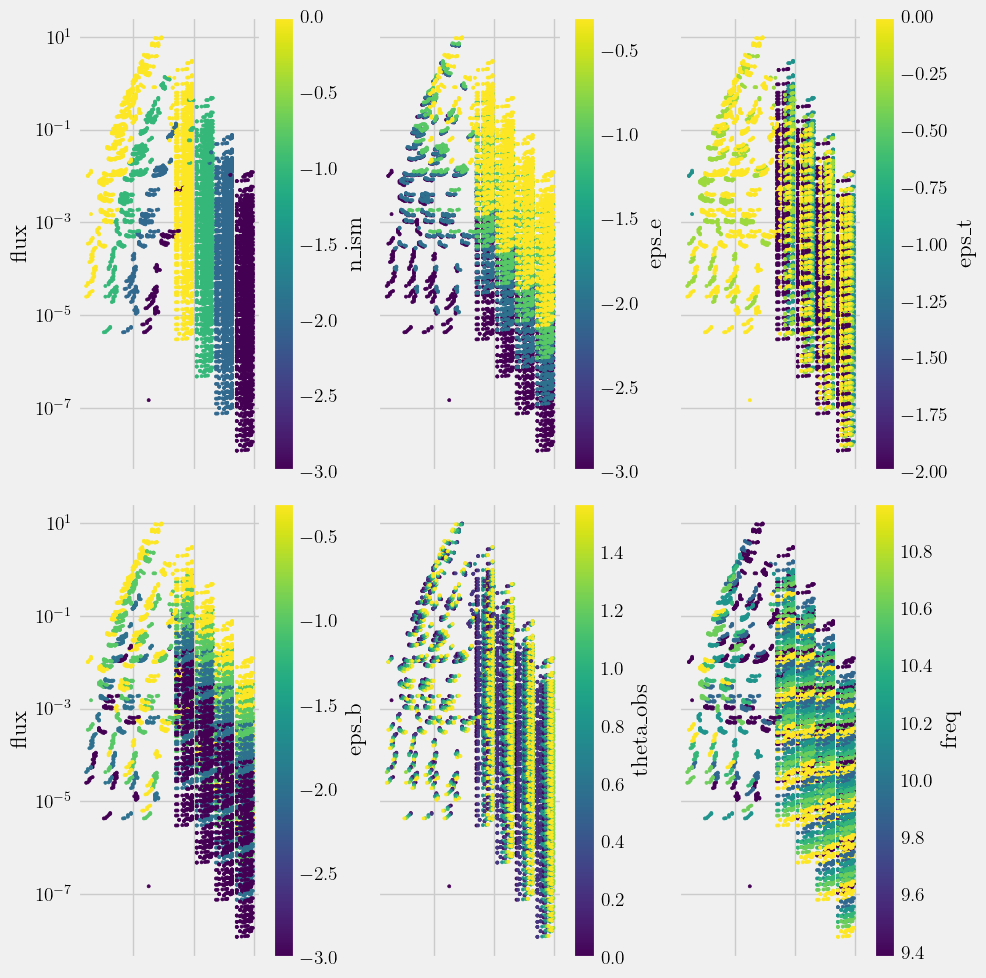

In [12]:
# plot data
fig,axes = plt.subplots(ncols=3,nrows=2,sharex="all",sharey="all",figsize=(10,10))
max_fluxes.plot.scatter(ax=axes[0][0], x="time",y="flux",c="n_ism",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[0][1], x="time",y="flux",c="eps_e",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[0][2], x="time",y="flux",c="eps_t",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][0], x="time",y="flux",c="eps_b",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][1], x="time",y="flux",c="theta_obs",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][2], x="time",y="flux",c="freq",colorbar=True,norm=colors.Normalize(),size=5)
plt.xscale("log")
plt.yscale("log")
plt.show()

<AxesSubplot: xlabel='time', ylabel='flux'>

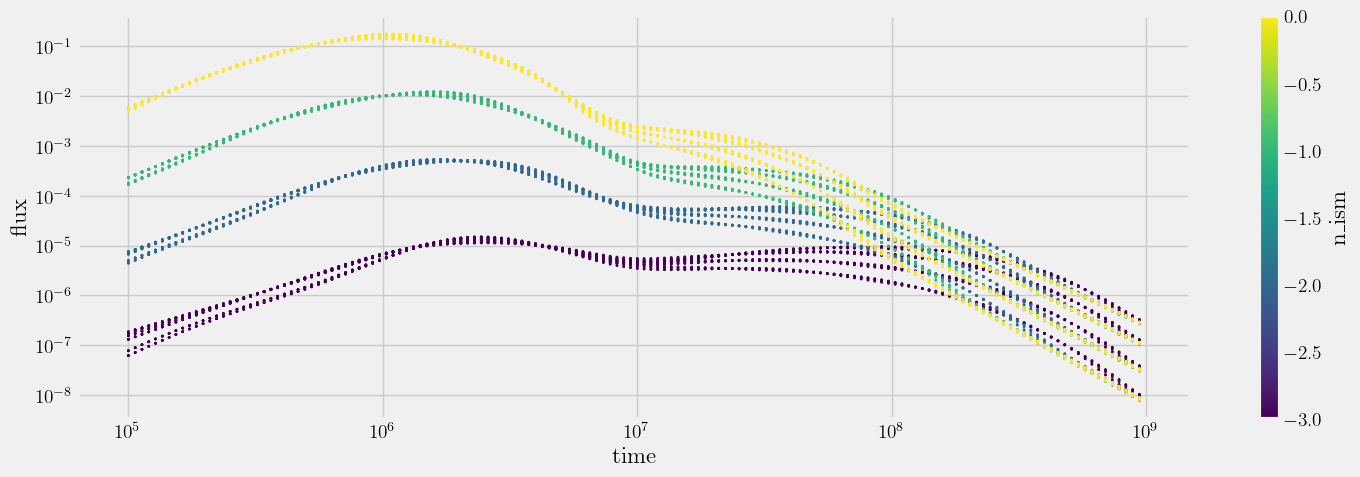

In [13]:
# Plot one batch of simulations

df_ = df[(df["freq"]==np.log10(2.4e9)) & (df["eps_b"]==np.log10(1e-2))&(df["eps_e"]==np.log10(1e-2))&(df["eps_t"]==np.log10(1.))]
df_.plot.scatter(x="time",y="flux",c="n_ism",colorbar=True,norm=colors.Normalize(),size=2,figsize=(15,5),loglog=True)


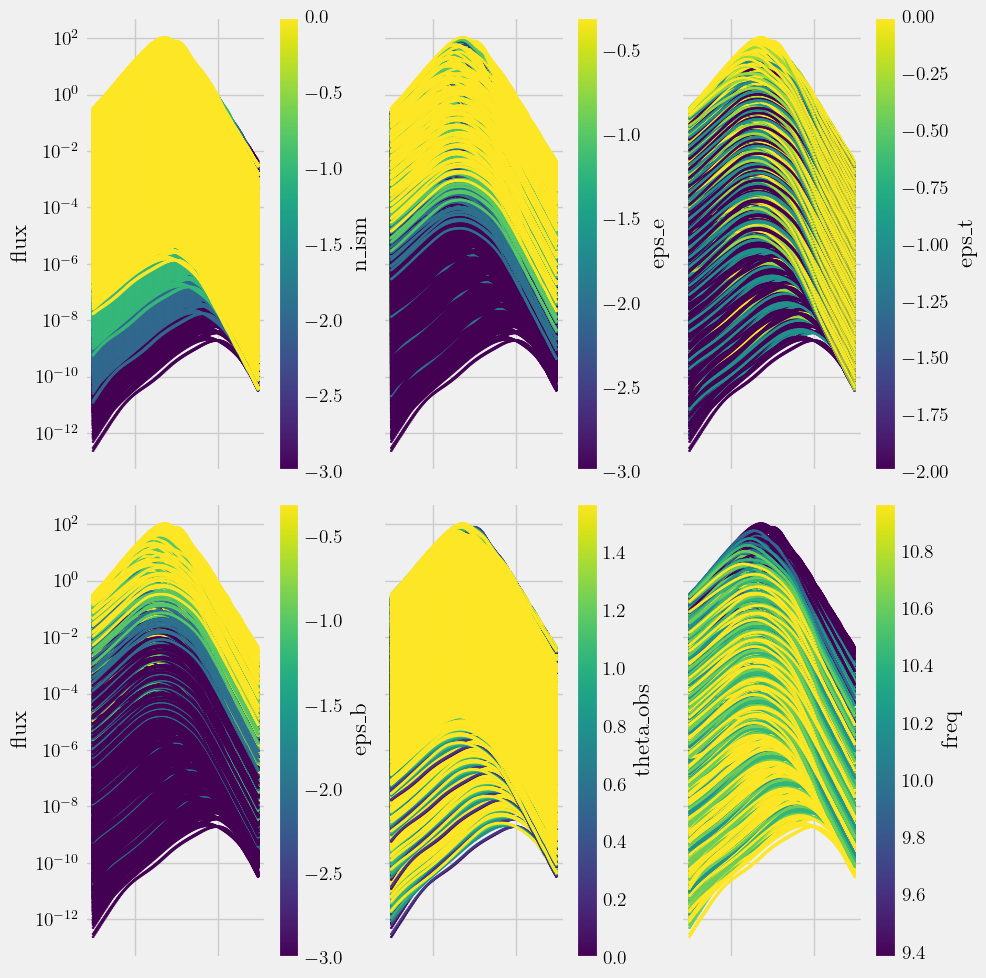

In [34]:
# plot data
fig,axes = plt.subplots(ncols=3,nrows=2,sharex="all",sharey="all",figsize=(10,10))
df.plot.scatter(ax=axes[0][0], x="time",y="flux",c="n_ism",colorbar=True,norm=colors.Normalize(),size=2)
df.plot.scatter(ax=axes[0][1], x="time",y="flux",c="eps_e",colorbar=True,norm=colors.Normalize(),size=2)
df.plot.scatter(ax=axes[0][2], x="time",y="flux",c="eps_t",colorbar=True,norm=colors.Normalize(),size=2)
df.plot.scatter(ax=axes[1][0], x="time",y="flux",c="eps_b",colorbar=True,norm=colors.Normalize(),size=2)
df.plot.scatter(ax=axes[1][1], x="time",y="flux",c="theta_obs",colorbar=True,norm=colors.Normalize(),size=2)
df.plot.scatter(ax=axes[1][2], x="time",y="flux",c="freq",colorbar=True,norm=colors.Normalize(),size=2)
plt.xscale("log")
plt.yscale("log")
plt.show()

# Statistics 

> Find what microphysics quantity is the most importnat in determing the peak time and peak flux

- Mutual Information(Entropy) assumes independent predictions, says how much information predictor gives on the target $I(X;Y) = H(X) - H(X|Y)$, where $H(\cdot)$ is the entropy. The result is in 'bits'.  
- ...

#### Mutual information (MI) 
between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?  
MI is univariate metric

In [22]:
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [24]:
def make_mi_scores(X : pd.DataFrame, y : np.array, discrete_features):
    # mi_scores = mutual_info_regression(X, y)
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [25]:
features = ["eps_e","eps_b","eps_t","n_ism","theta_obs","freq"]

In [26]:
X = df.copy()
y = X.pop("time")
X = X.loc[:,features]
mi_scores = make_mi_scores(X,y,None)
print(f"MI scores for Time")
print(mi_scores)
plot_mi_scores(mi_scores)
plt.show()


ValueError: Unknown label type: 'continuous'

MI scores for Flux
eps_b        0.149972
n_ism        0.143079
eps_e        0.104693
theta_obs    0.058096
Name: MI Scores, dtype: float64


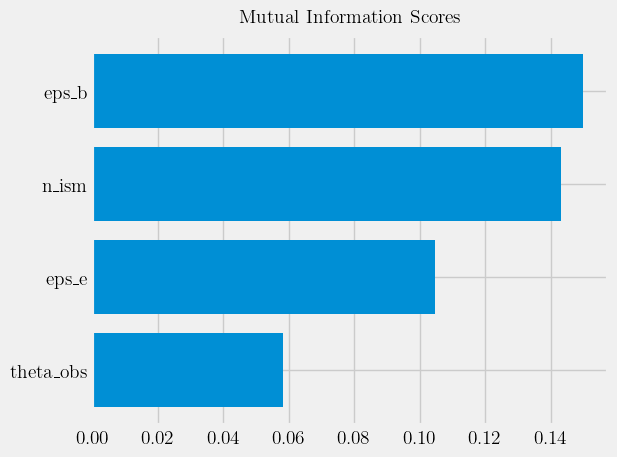

In [13]:
X = df.copy()
y = X.pop("flux")
X = X.loc[:,features]
mi_scores = make_mi_scores(X,y,None)
print(f"MI scores for Flux")
print(mi_scores)
plot_mi_scores(mi_scores)
plt.show()

In [14]:
print(df.isnull().sum())
print(df.isna().sum())
from sklearn.decomposition import PCA
print(df.keys())

eps_e        0
eps_b        0
n_ism        0
theta_obs    0
freq         0
time         0
flux         0
dtype: int64
eps_e        0
eps_b        0
n_ism        0
theta_obs    0
freq         0
time         0
flux         0
dtype: int64
Index(['eps_e', 'eps_b', 'n_ism', 'theta_obs', 'freq', 'time', 'flux'], dtype='object')


RF train accuracy: 0.143


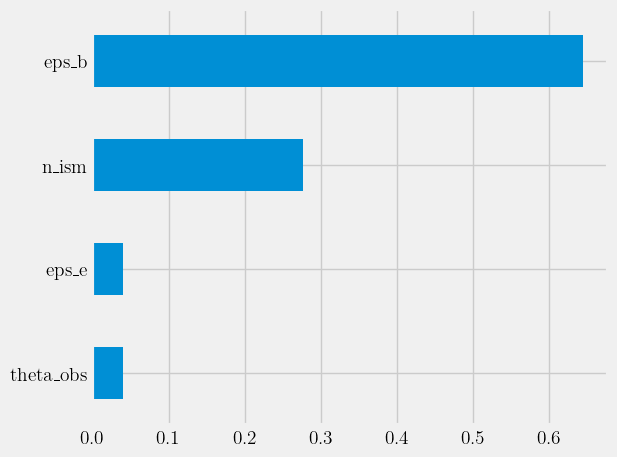

KeyboardInterrupt: 

In [15]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor(
         n_estimators=400,
         n_jobs=-1,
         min_samples_leaf = 20,
         oob_score=True,
         random_state = 42)
X = df.copy()
y = X.pop("flux")
X = X.loc[:,features]
_X = np.array(X)
_y = np.array(y)
rf.fit(_X, _y)
print(f"RF train accuracy: {rf.score(_X, _y):.3f}")
feat_importances = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.show()

from sklearn.inspection import permutation_importance
#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, _X, _y, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,1,figsize=(15,5))
importances_train.plot.box(vert=False, whis=10, ax = axs)
axs.set_title("Permutation Importances (train set)")
axs.axvline(x=0, color="k", linestyle="--")
axs.set_xlabel("Decrease in accuracy score")
axs.figure.tight_layout()
plt.show()


RF train accuracy: -0.000


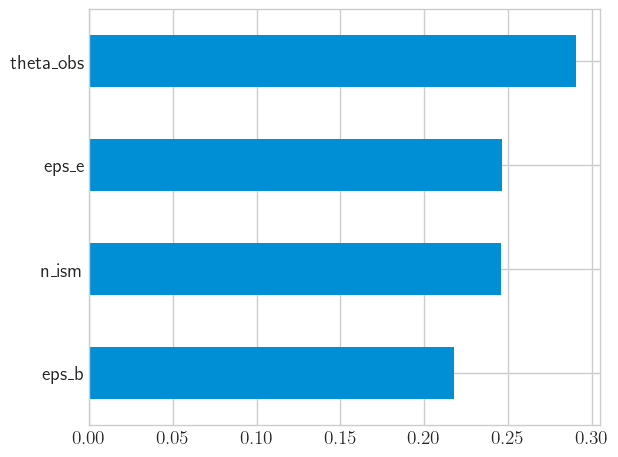

In [ ]:
rf = RandomForestRegressor(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
X = df.copy()
y = X.pop("time")
X = X.loc[:,features]
_X = np.array(X)
_y = np.array(y)
rf.fit(_X, _y)
print(f"RF train accuracy: {rf.score(_X, _y):.3f}")
feat_importances = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.show()

### On the importance of permutation:
Default feature importances are not accurate when you have an overfitting.  
Impurity-based importances are biased towards high-cardinality and numerical features.
When a model overfits, it picks up too much noise from the training set to make generalized predictions on the test set. When this happens, the feature importances are not reliable as they are calculated based on the training set.   
See also Bias in random forest variable importance measures (Strobl et al)

An alternative way is to calculate drop-column importance. I.e., alculate the model performance with all predictors and drop a single predictor and see the reduction in the performance. It has high computation cost. 

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.30238142],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.50246529],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.46652194],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.04303405],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        , -0.25446197],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        , -0.2454623 ],
       [ 0.30238142,  0.50246529,  0.46652194,  0.04303405, -0.25446197,
        -0.2454623 ,  1.        ]])


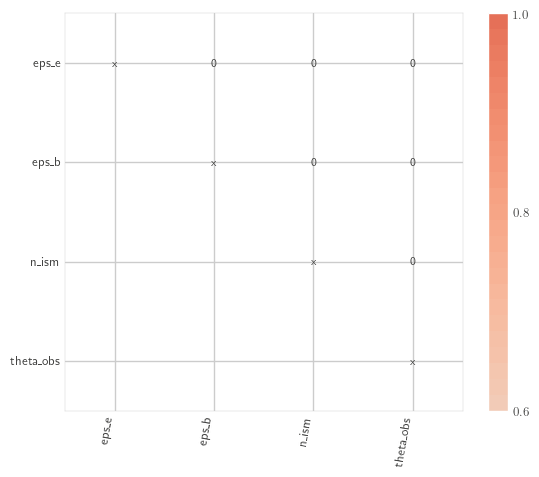

In [ ]:
from rfpimp import plot_corr_heatmap
from scipy.stats import spearmanr

X = df.copy()
y = X.pop("flux")
X = X.loc[:,features]
corr = spearmanr(df).correlation
print(repr(corr))

viz = plot_corr_heatmap(X, figsize=(7,5), precision=10)
viz.view()